#Алгоритм агрегации

In [ ]:
import pandas as pd
import re
import networkx as nx
import nltk
import spacy


from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [3]:
df_122 = pd.read_csv("lex_122.csv")[:123]
df_122 = df_122.drop(columns=["YandexGPT", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"])

In [6]:
df_33 = pd.read_csv("lex_33.csv")
df_33 = df_33.drop(columns=["Unnamed: 4", "Qwen2.5", "t5-trivia", "Falcon3 3B Instruct"]).reindex(columns=['Предложения', 'DeepSeek-V3', 'GPT-3.5', 'Llama-3.3'])

1. Построение графа

In [109]:
sentences = [
"Свет своих знаний и идеалов декабристы сохранили даже в мраке тюрьмы и несли просвещение другим заключённым.",
'Свет своих знаний и идеалов спасли декабристы от мрака тюрьмы, и они принесли просвещение другим заключенным.',
'Свет своих знаний и идеалов спас декабристов от мрака тюрьмы, и они принесли просвещение другим заключенным.',
'Свет своих образования и идеалов спасал декабристов от мрака тюрьмы, и они принесли просвещение другим заключенным.'
    ]

def build_graph(sentences):
    """
    Строит направленный граф токенов (nx.DiGraph). 
    Узлы — токены, рёбра соединяют последовательные токены.
    START — начальная вершина, END — конечная.
    """
    G = nx.DiGraph()
    start_node = "START"
    G.add_node(start_node)

    for sentence in sentences:
        tokens = word_tokenize(sentence, language='russian') + ["END"]
        current_node = start_node

        for token in tokens:
            existing_nodes = [node for node in G.nodes if G.nodes[node].get('word') == token]

            if existing_nodes:
                connected_nodes = [node for node in existing_nodes if G.has_edge(current_node, node)]
                if connected_nodes:
                    next_node = connected_nodes[0]
                    G.edges[current_node, next_node]['weight'] += 1
                else:
                    next_node = existing_nodes[0]
                    G.add_edge(current_node, next_node, weight=1)
            else:
                next_node = f"node_{len(G.nodes)}"
                G.add_node(next_node, word=token)
                G.add_edge(current_node, next_node, weight=1)

            current_node = next_node

    return G

In [62]:
def draw_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    node_labels = {node: G.nodes[node].get('word', node) for node in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_weight='bold')
    edge_weights = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
    plt.axis('off')
    plt.show()

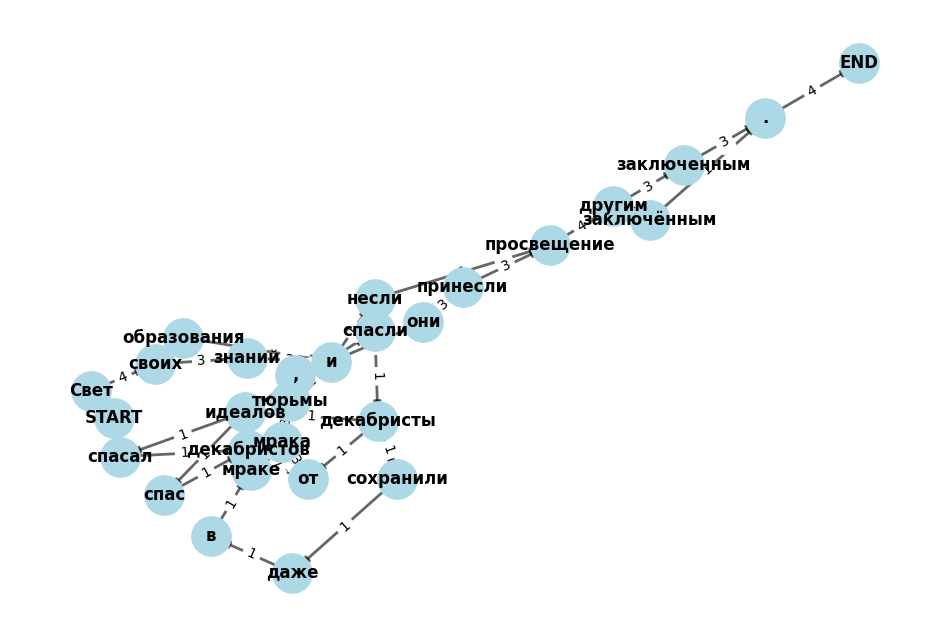

In [68]:
graph = build_graph(sentences)
draw_graph(graph)

In [ ]:
2.Подсчет перплексии 

In [79]:
import torch
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [73]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
model_name = "sberbank-ai/ruT5-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruT5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("sberbank-ai/ruT5-base").to(device)
model.eval()

In [123]:
model_name = "sberbank-ai/ruT5-large"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruT5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("sberbank-ai/ruT5-large").to(device)
model.eval()

: 

In [119]:
def calculate_perplexity(sentence):
    #считаем перплексию предложения по модели ruT5-base.
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        loss = model(**inputs, labels=inputs["input_ids"]).loss
    return torch.exp(loss).item()

In [115]:
def greedy(G, start_node="START", max_len=20):
    """
    Жадный поиск по графу:
    1. Первое слово после START выбирается по частоте ребра (если несколько, берём первое).
    2. Далее добавляем токены жадно, минимизируя перплексию.
    3. Остановка при достижении END или max_len.
    """
    current = start_node
    chain = []

    # 1. Выбираем первое слово после START
    successors = list(G.successors(current))
    if not successors:
        return chain

    # выбираем по частоте ребра
    successors.sort(key=lambda n: (-G.edges[current, n]['weight'], n))
    first_node = successors[0]
    first_token = G.nodes[first_node]['word']
    if first_token == "END":
        return chain
    chain.append(first_token)
    current = first_node

    # 2. Жадное добавление следующих токенов
    for _ in range(max_len - 1):
        successors = list(G.successors(current))
        if not successors:
            break

        best_ppl = float('inf')
        best_node = None

        for next_node in successors:
            token = G.nodes[next_node]['word']
            if token == "END":
                best_node = next_node
                break

            sentence = " ".join(chain + [token])
            ppl = calculate_perplexity(sentence)

            if ppl < best_ppl:
                best_ppl = ppl
                best_node = next_node

        if best_node is None or G.nodes[best_node]['word'] == "END":
            break

        chain.append(G.nodes[best_node]['word'])
        current = best_node

    return chain

In [110]:
G = build_graph(sentences)
best_chain = greedy(G, start_node="START", max_len=20)
print("→", " ".join(best_chain))

→ Свет своих знаний и несли просвещение другим заключённым .


In [ ]:
for index, row in df_33.iterrows():
    sentences = row.tolist()  # превращаем строку в список
    for sentence in sentences:
        print(sentence, calculate_perplexity(sentence))

Я хочу научиться играть на фортопиане. 17.665903091430664
Я хочу научиться играть на фортепиано. 7.575138092041016
Я хочу научиться играть на фортепиано. 7.575138092041016
Я хочу научиться играть на фортепиано. 7.575138092041016
Без лидеров в мире было бы беспорядок, потому что человек не может жить без правилов. 18.39301300048828
Без лидеров в мире был бы беспорядок, потому что человек не может жить без правил. 13.806864738464355
Без лидеров в мире был бы беспорядок, потому что человек не может жить без правил. 13.806864738464355
Без лидеров в мире был бы беспорядок, потому что человек не может жить без правил. 13.806864738464355
Некоторые из кафедр считаются межфакультетными. 54.332088470458984
Некоторые из кафедр считаются межфакультетными. 54.332088470458984
Некоторые кафедры считаются межфакультетскими. 217.7113494873047
Некоторые из кафедр считаются межфакультетскими. 33.16736602783203
Фонтан безконечно работает и вода постоянно слышно. 88.77029418945312
Фонтан бесконечно работае